In [ ]:
!pip install pypots==0.11

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: pypots
    Found existing installation: pypots 0.12
    Uninstalling pypots-0.12:
      Successfully uninstalled pypots-0.12


In [ ]:
import missingno as msno
import pandas as pd
import numpy as np
from pypots.imputation import SAITS

/usr/local/lib/python3.11/dist-packages/pypots/nn/functional/cuda.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return autocast(**kwargs)



████████╗██╗███╗   ███╗███████╗    ███████╗███████╗██████╗ ██╗███████╗███████╗    █████╗ ██╗
╚══██╔══╝██║████╗ ████║██╔════╝    ██╔════╝██╔════╝██╔══██╗██║██╔════╝██╔════╝   ██╔══██╗██║
   ██║   ██║██╔████╔██║█████╗█████╗███████╗█████╗  ██████╔╝██║█████╗  ███████╗   ███████║██║
   ██║   ██║██║╚██╔╝██║██╔══╝╚════╝╚════██║██╔══╝  ██╔══██╗██║██╔══╝  ╚════██║   ██╔══██║██║
   ██║   ██║██║ ╚═╝ ██║███████╗    ███████║███████╗██║  ██║██║███████╗███████║██╗██║  ██║██║
   ╚═╝   ╚═╝╚═╝     ╚═╝╚══════╝    ╚══════╝╚══════╝╚═╝  ╚═╝╚═╝╚══════╝╚══════╝╚═╝╚═╝  ╚═╝╚═╝
ai4ts v0.0.3 - building AI for unified time-series analysis, https://time-series.ai 



In [ ]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/dataset2_cuenca.csv')
df

,FECHA,QH0889,QH0894,PRECIPITACION M0141,PRECIPITACION M0501,PRECIPITACION M0431,SST,SPI M0141,SPI M0501,SPI M0431
0,1980-01,54.521,15.784,119.3,245.5,NaN,27.16,0.37,0.88,NaN
1,1980-02,54.666,30.408,120.2,31.4,NaN,27.57,0.39,-1.51,NaN
2,1980-03,120.460,37.035,128.8,161.2,NaN,27.85,0.57,-0.06,NaN
3,1980-04,110.465,85.364,156.6,224.3,NaN,28.18,1.16,0.65,NaN
4,1980-05,92.278,46.099,75.3,82.8,NaN,28.17,-0.56,-0.93,NaN
...,...,...,...,...,...,...,...,...,...,...
463,2018-08,61.781,41.290,NaN,NaN,NaN,27.53,NaN,NaN,NaN
464,2018-09,61.781,41.290,NaN,NaN,NaN,27.61,NaN,NaN,NaN
465,2018-10,61.781,41.290,NaN,NaN,NaN,27.73,NaN,NaN,NaN
466,2018-11,61.781,41.290,NaN,NaN,NaN,27.83,NaN,NaN,NaN


<Axes: >

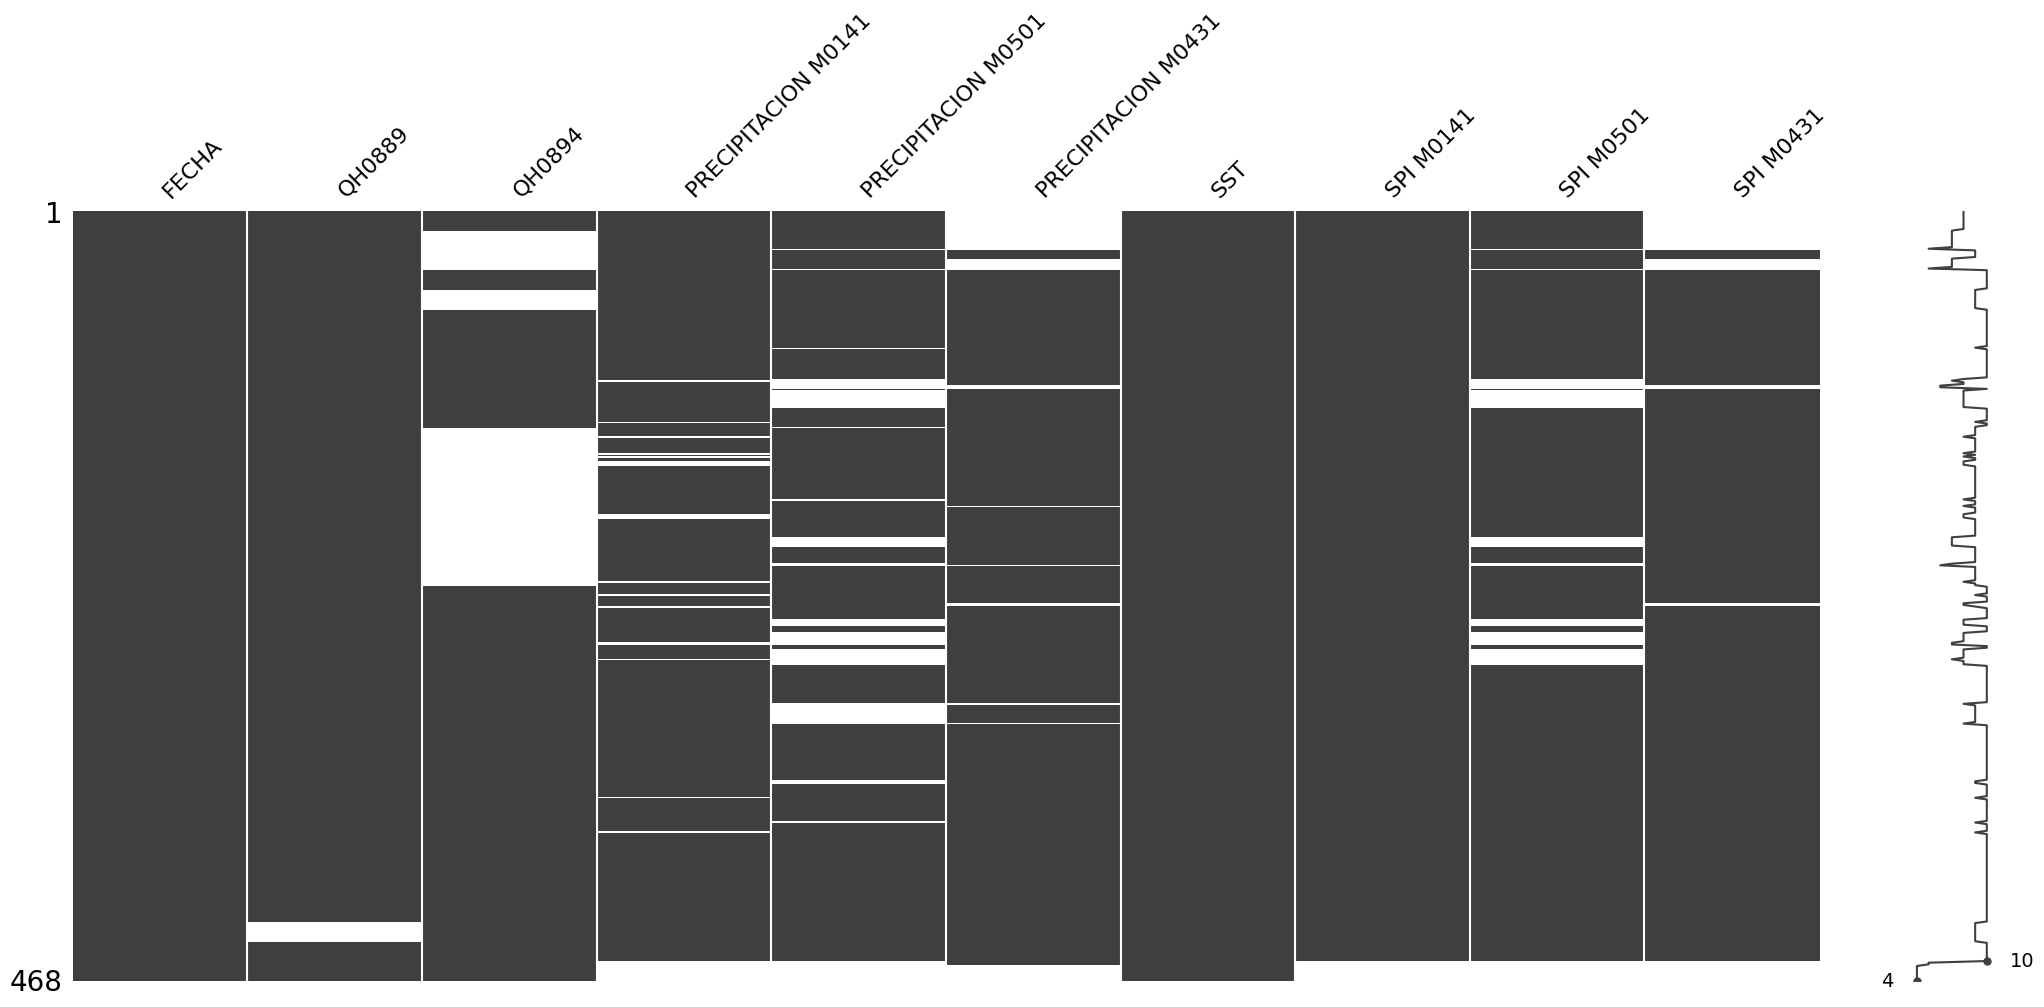

In [ ]:
msno.matrix(df)

In [ ]:
# Data preprocessing. Tedious, but PyPOTS can help.
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar
from pypots.imputation import SAITS
from pypots.utils.metrics import calc_mae

2025-03-14 01:38:11 [WARNING]: ‼️ `pypots.utils.metrics` is deprecated. Please import from `pypots.nn.functional` instead.


In [ ]:
# Convert 'FECHA' to datetime and set as index
df = pd.read_csv('https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/dataset2_cuenca.csv')
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m')
df.set_index('FECHA', inplace=True)

# Parámetros
seq_len = 36  # Longitud de las ventanas en meses
n_features = len(df.columns)  # Número de variables

# Convertir los datos en un array numpy
data = df.to_numpy(dtype=np.float32)

# Crear ventanas deslizantes
n_samples = len(data) - seq_len + 1
X = np.array([data[i:i + seq_len] for i in range(n_samples)])

X.shape

(433, 36, 9)

In [ ]:
# Compute the number of times each row should be repeated
repeat_factor = data.shape[0] // X.shape[0]  # repetitions
extra_rows = data.shape[0] % X.shape[0] # additional rows needed

# Repeat all rows equally
expanded_arr = np.repeat(X, repeat_factor, axis=0)

# Add extra rows from the beginning to match 468
expanded_arr = np.vstack([expanded_arr, X[:extra_rows]])

expanded_arr.shape

(468, 36, 9)

In [ ]:
expanded_arr[-extra_rows:,0,:] = data[-extra_rows:]
expanded_arr.shape

(468, 36, 9)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Inicializar normalizador para cada feature
scaler = MinMaxScaler()

X = expanded_arr.copy()

# Reajustar la forma para normalizar correctamente (colapsando las dimensiones temporales y de muestras)
X_reshaped = X.reshape(-1, X.shape[-1])  # Convertimos a (total_rows, n_features)

# Ajustar y transformar los datos
X_scaled = scaler.fit_transform(X_reshaped)

# Restaurar la forma original (n_samples, seq_len, n_features)
X_scaled = X_scaled.reshape(X.shape)

print("Shape de X escalado:", X_scaled.shape)

Shape de X escalado: (468, 36, 9)


In [ ]:
# Initialize SAITS model
saits = SAITS(n_steps=seq_len, n_features=n_features,
              n_layers=2, d_model=256, d_ffn=128,
              n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=100)

dataset = {"X": X_scaled}

# Train the model
# Model training. This is PyPOTS showtime.
# Here I use the whole dataset as the training set because ground truth is not visible to the model, you can also split it into train/val/test sets
saits.fit(dataset)  # train the model on the dataset
imputation = saits.impute(dataset)  # impute the originally-missing values

2025-03-14 01:38:19 [INFO]: No given device, using default device: cpu
2025-03-14 01:38:19 [WARNING]: ‼️ saving_path not given. Model files and tensorboard file will not be saved.
2025-03-14 01:38:19 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,331,210
2025-03-14 01:38:23 [INFO]: Epoch 001 - training loss (MSE): 0.2305
2025-03-14 01:38:27 [INFO]: Epoch 002 - training loss (MSE): 0.0869
2025-03-14 01:38:30 [INFO]: Epoch 003 - training loss (MSE): 0.0724
2025-03-14 01:38:33 [INFO]: Epoch 004 - training loss (MSE): 0.0665
2025-03-14 01:38:37 [INFO]: Epoch 005 - training loss (MSE): 0.0622
2025-03-14 01:38:41 [INFO]: Epoch 006 - training loss (MSE): 0.0580
2025-03-14 01:38:44 [INFO]: Epoch 007 - training loss (MSE): 0.0547
2025-03-14 01:38:47 [INFO]: Epoch 008 - training loss (MSE): 0.0502
2025-03-14 01:38:52 [INFO]: Epoch 009 - training loss (MSE): 0.0455
2025-03-14 01:38:55 [INFO]: Epoch 010 - training loss (MSE): 0.0403
2025-03-14 01:38

In [ ]:
imputation.shape

(468, 36, 9)

In [ ]:
# Asegúrate de reshaping correcto para la desnormalización
imputation_reshaped = imputation.reshape(-1, imputation.shape[-1])  # (n_samples * seq_len, n_features)

# Desnormalizar
imputation_denorm = scaler.inverse_transform(imputation_reshaped)

# Restaurar la forma original
imputation_denorm = imputation_denorm.reshape(imputation.shape)
imputation_denorm.shape

(468, 60, 9)

In [ ]:
# Extraer datos imputados para el intervalo removido
imputed_values = imputation_denorm[:, 0, :]
imputed_values.shape

(468, 9)

In [ ]:
data_imputed = pd.DataFrame(imputed_values, columns=df.columns, index=df.index[:imputed_values.shape[0]])
data_imputed

,QH0889,QH0894,PRECIPITACION M0141,PRECIPITACION M0501,PRECIPITACION M0431,SST,SPI M0141,SPI M0501,SPI M0431
FECHA,,,,,,,,,
1980-01-01,54.521000,15.784000,119.300011,245.500000,109.133606,27.160000,0.370000,0.880000,-0.219983
1980-02-01,54.666000,30.408001,120.200005,31.400000,109.779770,27.570000,0.390000,-1.510000,-0.231909
1980-03-01,120.459999,37.035000,128.800003,161.199997,138.166382,27.850000,0.570000,-0.060000,0.267733
1980-04-01,110.464996,85.363998,156.600006,224.300003,154.360703,28.180000,1.160000,0.650000,0.571972
1980-05-01,92.278000,46.098999,75.300003,82.800003,125.318336,28.170000,-0.560000,-0.930000,0.051309
...,...,...,...,...,...,...,...,...,...
2018-08-01,61.780998,41.290001,88.242363,111.014915,122.999153,27.530001,-0.229375,-0.570098,0.056244
2018-09-01,61.780998,41.290001,89.573219,104.801804,120.238617,27.610001,-0.198555,-0.633013,0.002413
2018-10-01,61.780998,41.290001,91.036720,102.525620,117.423248,27.730000,-0.172473,-0.656152,-0.054880


<Axes: >

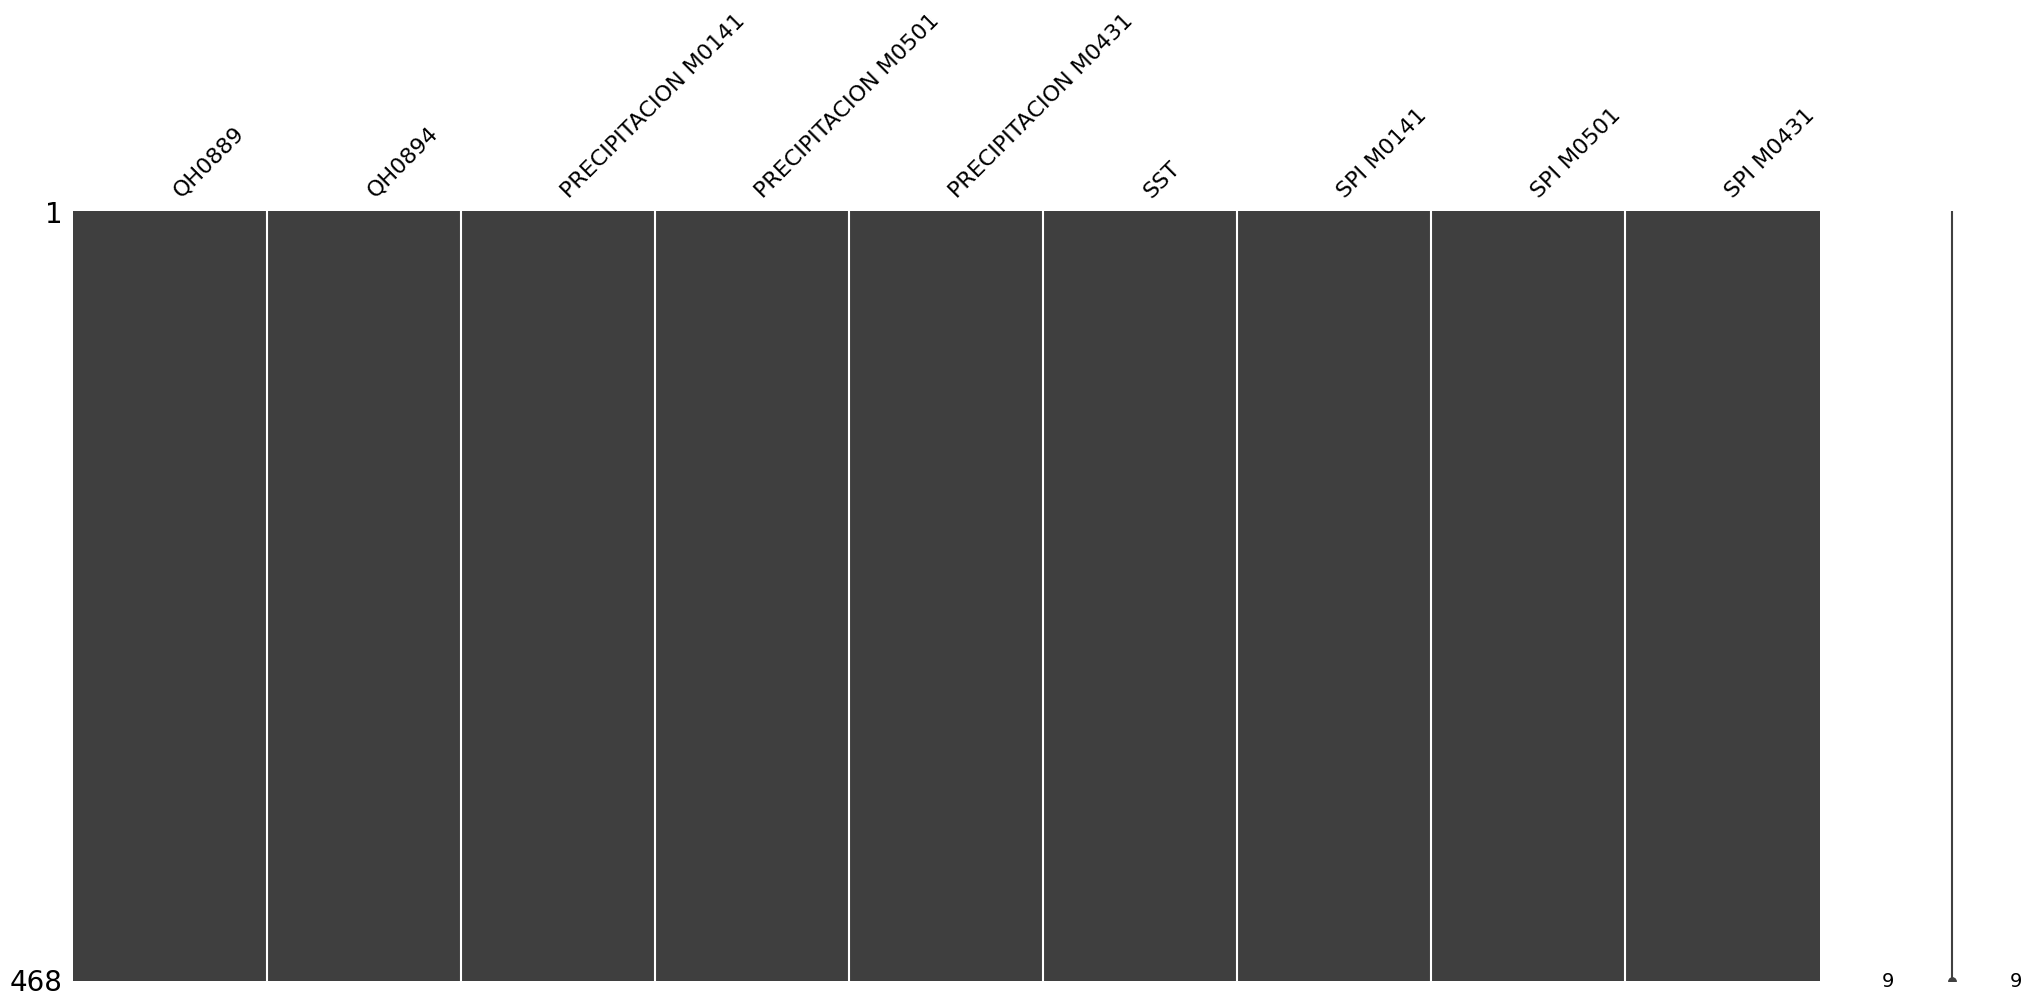

In [ ]:
msno.matrix(data_imputed)

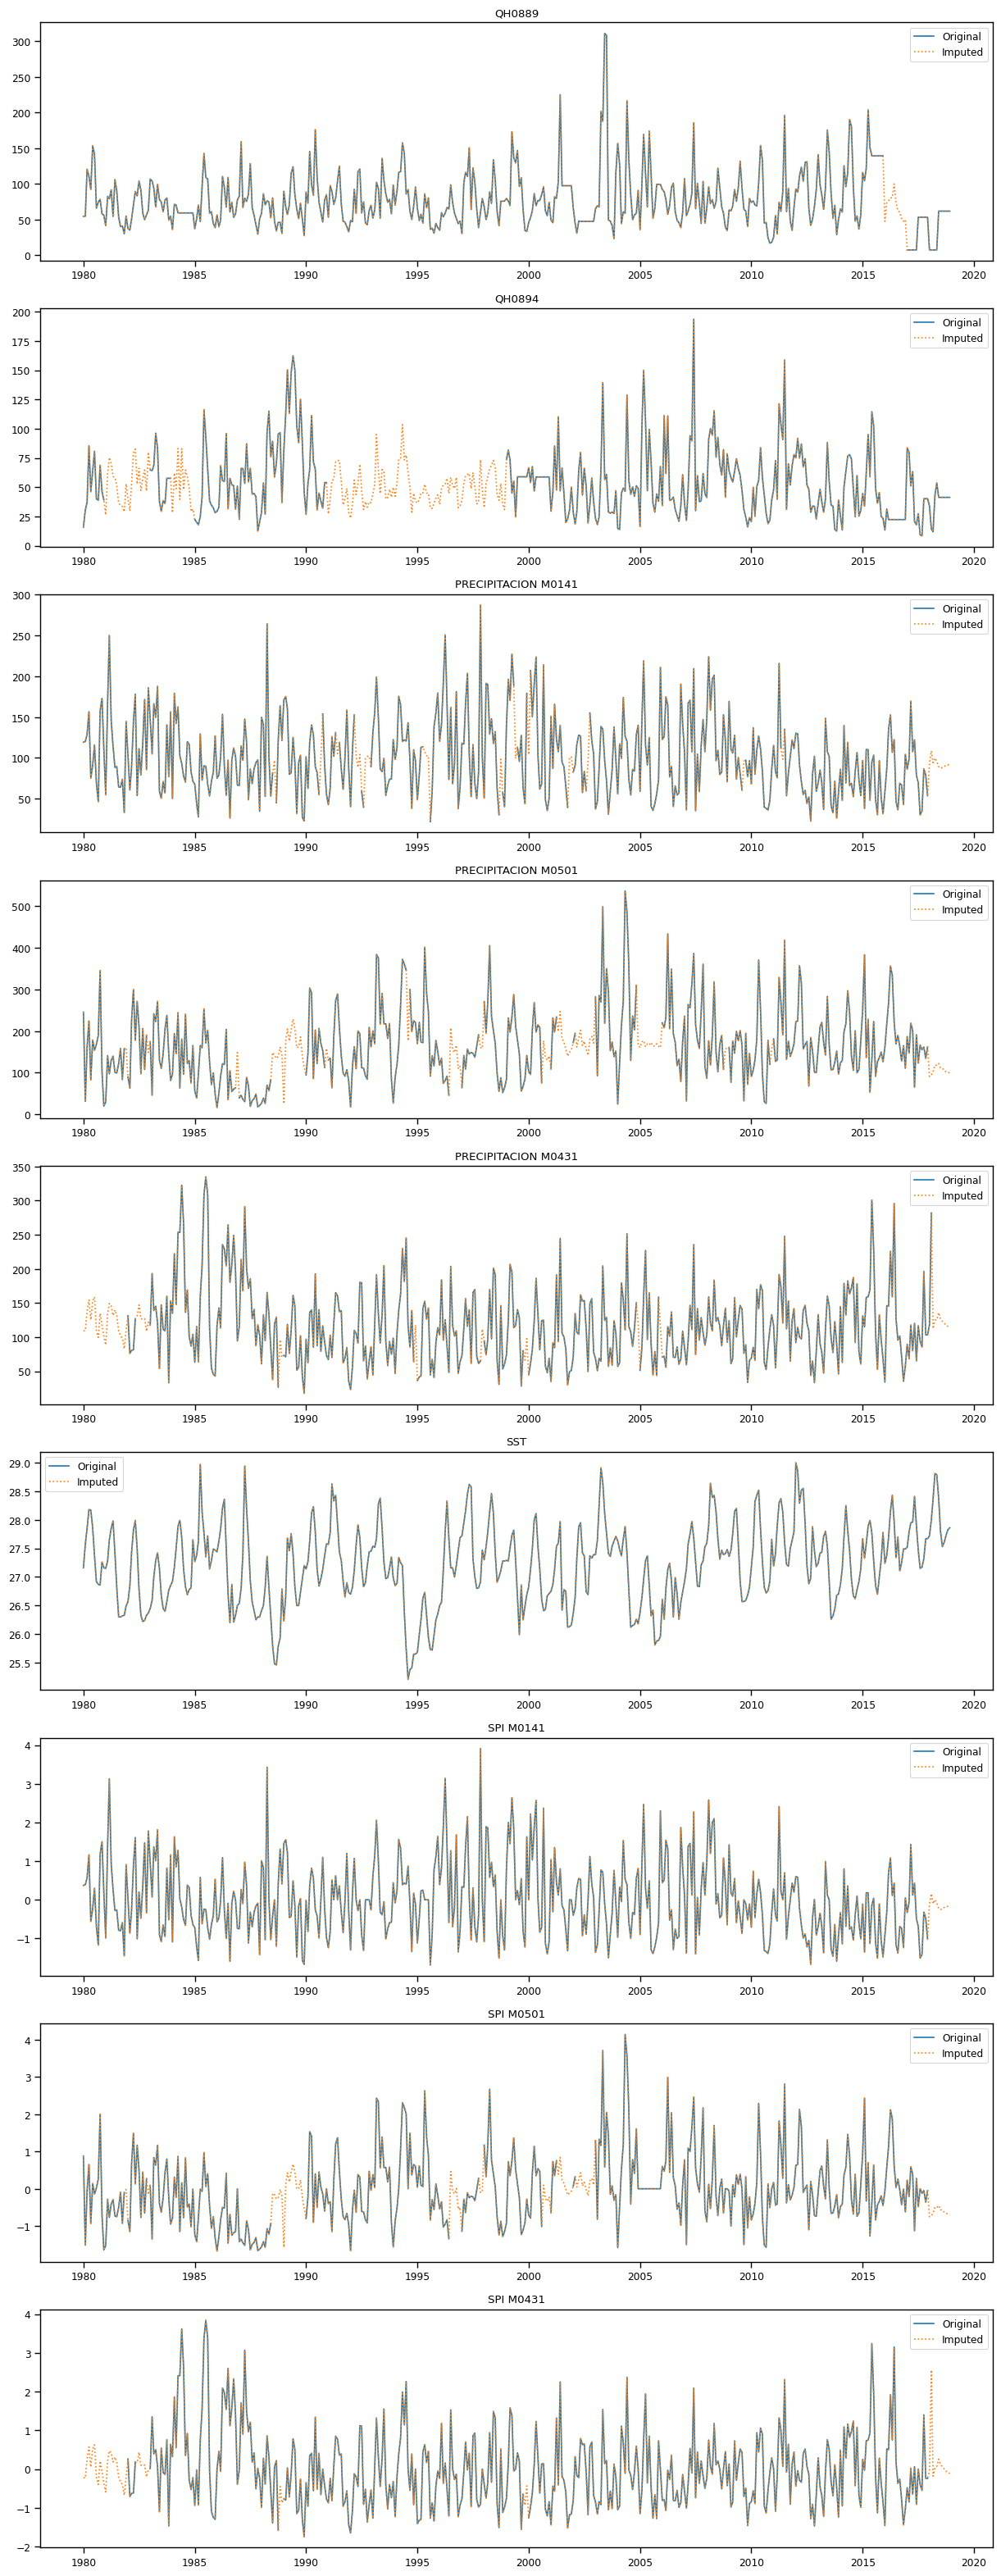

In [ ]:
import seaborn as sns
sns.set_context('paper')
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 40))

for i,col in enumerate(df.columns):
    plt.subplot(9,1,i+1)
    plt.plot(df.index, df[col], label="Original")
    plt.plot(data_imputed.index, data_imputed[col], ':', label="Imputed")
    plt.title(col)
    plt.legend()

In [ ]:
data_imputed.to_csv('dataset3_imputed.csv')

In [ ]:
# prompt: read this file with first column being a date column, dayfirst: https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/viz_data/ts_data_precipitation.csv

import pandas as pd

# Read the CSV file with the specified date format and dayfirst=True
data_imputed = pd.read_csv('https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/viz_data/ts_data_precipitation.csv',
                               parse_dates=[0], dayfirst=True, index_col=0)

# Display the first few rows of the DataFrame to verify
data_imputed.head()


,QH0889,QH0894,PM0141,PM0501,PM0431,SST,SPI M0141,SPI M0501,SPI M0431
FECHA,,,,,,,,,
1980-01-01,54.52,15.78,119.3,245.5,105.94,27.16,0.37,0.88,-0.30
1980-02-01,54.67,30.41,120.2,31.4,92.91,27.57,0.39,-1.51,-0.51
1980-03-01,120.46,37.04,128.8,161.2,118.66,27.85,0.57,-0.06,-0.06
1980-04-01,110.47,85.36,156.6,224.3,138.17,28.18,1.16,0.65,0.25
1980-05-01,92.28,46.10,75.3,82.8,103.27,28.17,-0.56,-0.93,-0.28


In [ ]:
# Convert 'FECHA' to datetime and set as index
df = pd.read_csv('https://raw.githubusercontent.com/marsgr6/r-scripts/refs/heads/master/data/dataset2_cuenca.csv')
df['FECHA'] = pd.to_datetime(df['FECHA'], format='%Y-%m')
df.set_index('FECHA', inplace=True)
df.head()

,QH0889,QH0894,PRECIPITACION M0141,PRECIPITACION M0501,PRECIPITACION M0431,SST,SPI M0141,SPI M0501,SPI M0431
FECHA,,,,,,,,,
1980-01-01,54.521,15.784,119.3,245.5,NaN,27.16,0.37,0.88,NaN
1980-02-01,54.666,30.408,120.2,31.4,NaN,27.57,0.39,-1.51,NaN
1980-03-01,120.460,37.035,128.8,161.2,NaN,27.85,0.57,-0.06,NaN
1980-04-01,110.465,85.364,156.6,224.3,NaN,28.18,1.16,0.65,NaN
1980-05-01,92.278,46.099,75.3,82.8,NaN,28.17,-0.56,-0.93,NaN


In [ ]:
# prompt: name the first 9 columns of df using the columns of data_imputed

# Assuming 'df' and 'data_imputed' are already defined as in your provided code.

# Check if the number of columns in 'data_imputed' is at least 9
if len(data_imputed.columns) >= 9:
  # Rename the first 9 columns of 'df'
  df.columns = list(data_imputed.columns[:9]) + list(df.columns[9:])
else:
  print("Error: 'data_imputed' does not have at least 9 columns.")

df.head()

,QH0889,QH0894,PM0141,PM0501,PM0431,SST,SPI M0141,SPI M0501,SPI M0431
FECHA,,,,,,,,,
1980-01-01,54.521,15.784,119.3,245.5,NaN,27.16,0.37,0.88,NaN
1980-02-01,54.666,30.408,120.2,31.4,NaN,27.57,0.39,-1.51,NaN
1980-03-01,120.460,37.035,128.8,161.2,NaN,27.85,0.57,-0.06,NaN
1980-04-01,110.465,85.364,156.6,224.3,NaN,28.18,1.16,0.65,NaN
1980-05-01,92.278,46.099,75.3,82.8,NaN,28.17,-0.56,-0.93,NaN


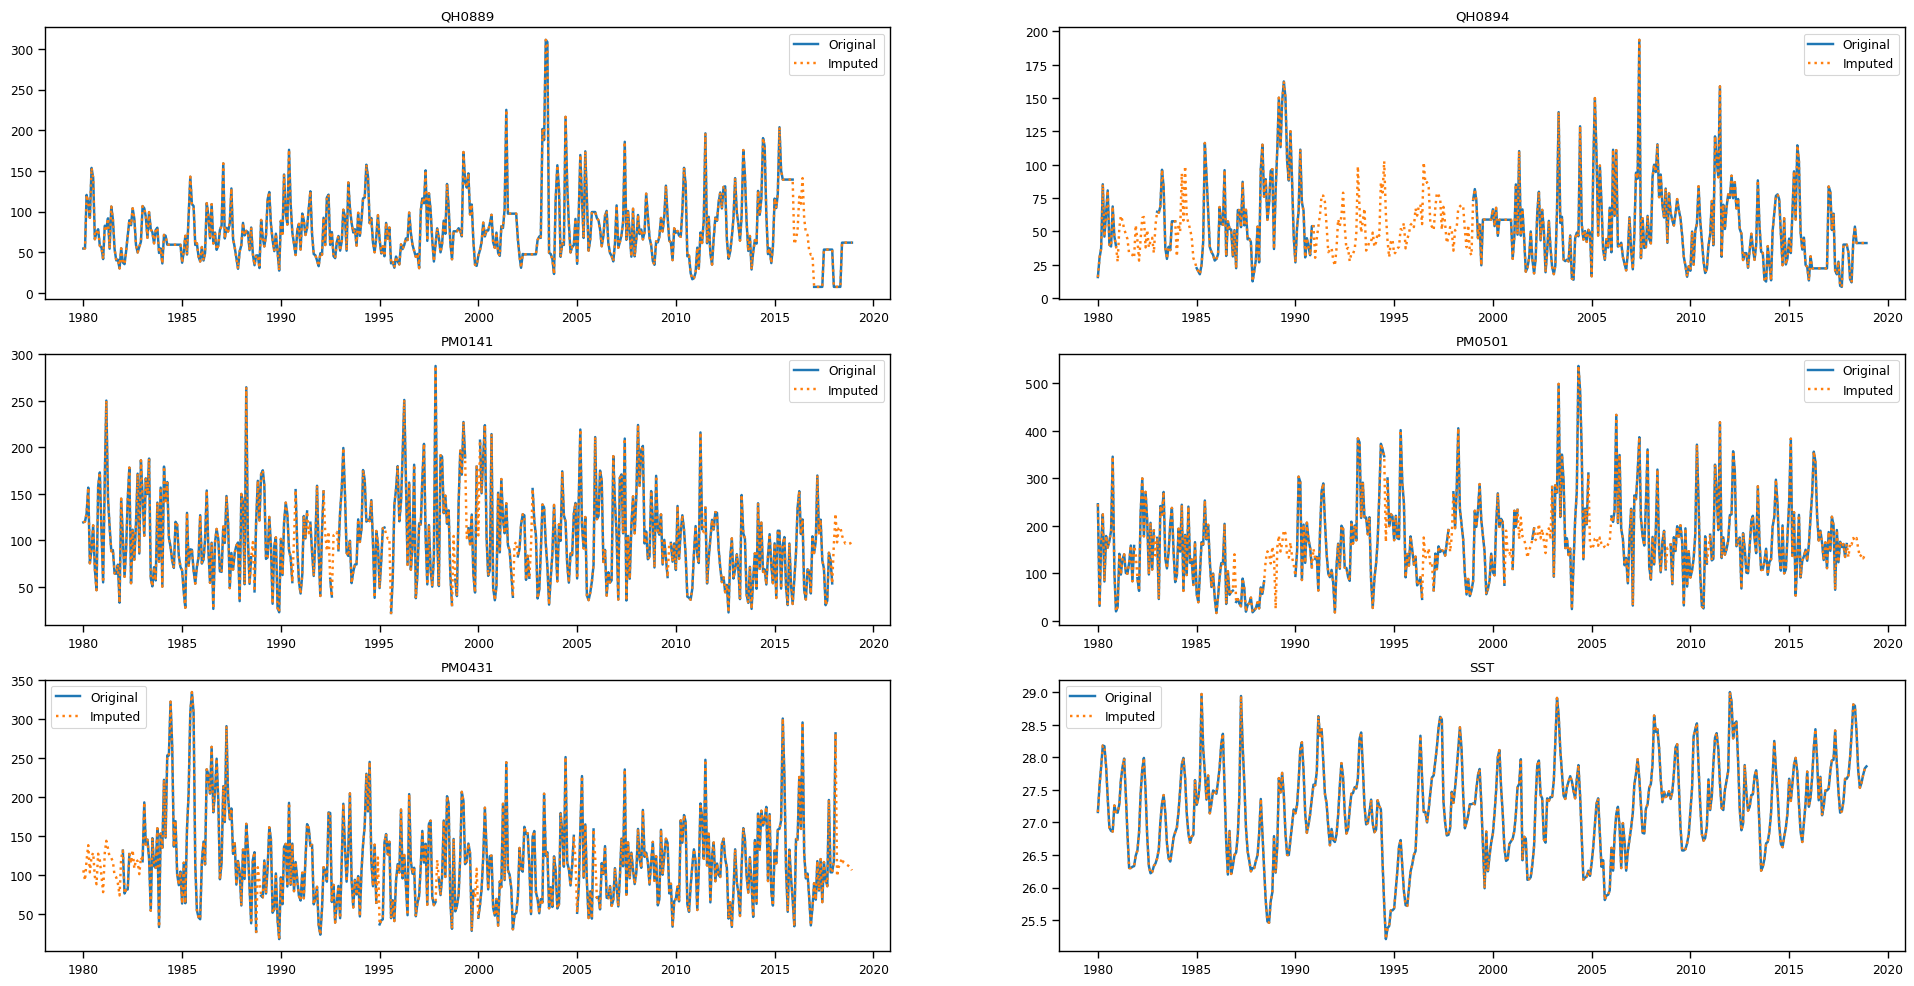

In [ ]:
import seaborn as sns
sns.set_context('paper')
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 12))

for i,col in enumerate(df.columns[:6]):
    plt.subplot(3,2,i+1)
    plt.plot(df.index, df[col], label="Original", linewidth=1.75)
    plt.plot(data_imputed.index, data_imputed[col], ':', label="Imputed", linewidth=1.75)
    plt.title(col)
    plt.legend()

[Transformer128] Epoch 1, Loss: 0.0358
[Transformer128] Epoch 2, Loss: 0.0008
[Transformer128] Epoch 3, Loss: 0.0005
[Transformer128] Epoch 4, Loss: 0.0005
[Transformer128] Epoch 5, Loss: 0.0005
[Transformer128] Epoch 6, Loss: 0.0005
[Transformer128] Epoch 7, Loss: 0.0005
[Transformer128] Epoch 8, Loss: 0.0005
[Transformer128] Epoch 9, Loss: 0.0004
[Transformer128] Epoch 10, Loss: 0.0004
[Transformer128] Epoch 11, Loss: 0.0004
[Transformer128] Epoch 12, Loss: 0.0004
[Transformer128] Epoch 13, Loss: 0.0003
[Transformer128] Epoch 14, Loss: 0.0004
[Transformer128] Epoch 15, Loss: 0.0003
[Transformer128] Epoch 16, Loss: 0.0004
[Transformer128] Epoch 17, Loss: 0.0003
[Transformer128] Epoch 18, Loss: 0.0003
[Transformer128] Epoch 19, Loss: 0.0003
[Transformer128] Epoch 20, Loss: 0.0004
[Transformer128] Epoch 21, Loss: 0.0004
[Transformer128] Epoch 22, Loss: 0.0003
[Transformer128] Epoch 23, Loss: 0.0003
[Transformer128] Epoch 24, Loss: 0.0003
[Transformer128] Epoch 25, Loss: 0.0004
[Transfor

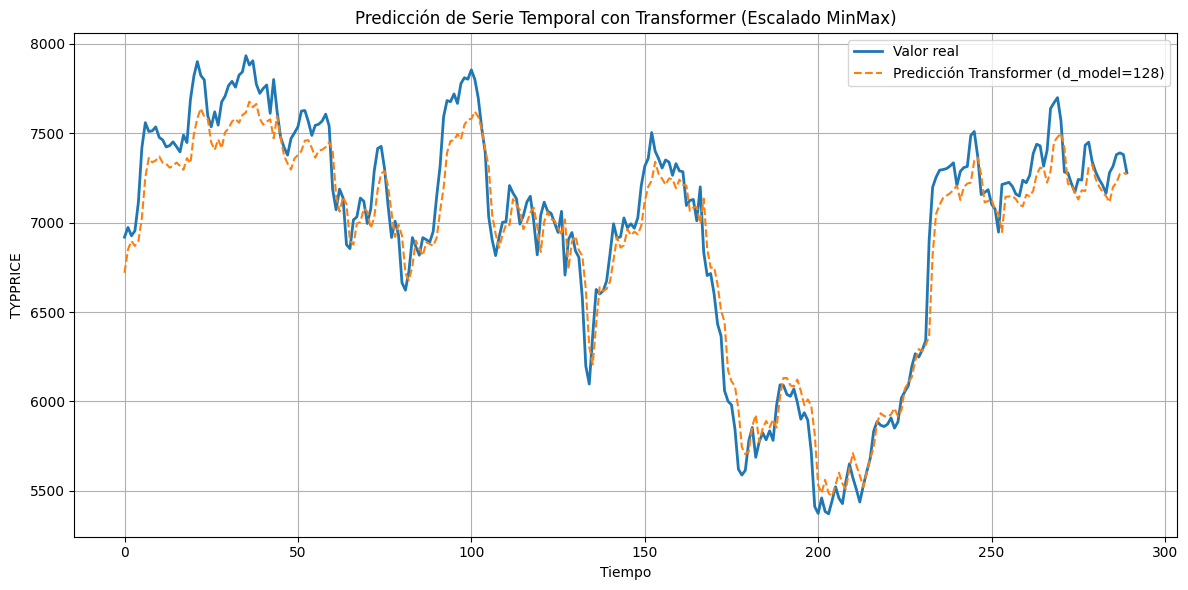

RMSE: 159.67
MAE: 127.16
MAPE: 1.81%
R²: 0.9427


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and prepare the data
url = "https://raw.githubusercontent.com/marsgr6/ml-online/main/data/BAJFINANCE_day__with_indicators_.csv"
df = pd.read_csv(url, parse_dates=["date"])
series = df["TYPPRICE"].dropna().values
train_series = series[:-300]
test_series = series[-300:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_series.reshape(-1, 1)).flatten()

# Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.seq_length],
                self.data[idx+self.seq_length])

seq_len = 10
train_dataset = TimeSeriesDataset(train_scaled, seq_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Transformer model with custom encoder layer
class TransformerTimeSeries(nn.Module):
    def __init__(self, seq_length, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=0.01,
            dim_feedforward=512,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)              # (B, L) → (B, L, 1)
        x = self.embedding(x)            # (B, L, 1) → (B, L, d_model)
        x = self.transformer(x)          # (B, L, d_model)
        x = x[:, -1, :]                  # Usar último token
        return self.fc(x).squeeze(-1)    # (B,)

# Model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerTimeSeries(seq_length=seq_len).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(30):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Transformer128] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
def create_test_windows(data, seq_length):
    return torch.stack([data[i:i+seq_length] for i in range(len(data) - seq_length)])

model.eval()
with torch.no_grad():
    test_tensor = torch.tensor(test_scaled, dtype=torch.float32)
    test_inputs = create_test_windows(test_tensor, seq_len).to(device)
    predictions = model(test_inputs).cpu().numpy()
    predictions_original = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

# Metrics
real = test_series[seq_len:]
rmse = np.sqrt(mean_squared_error(real, predictions_original))
mae = mean_absolute_error(real, predictions_original)
mape = np.mean(np.abs((real - predictions_original) / real)) * 100
r2 = r2_score(real, predictions_original)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(real, label="Valor real", linewidth=2)
plt.plot(predictions_original, label="Predicción Transformer (d_model=128)", linestyle="--")
plt.title("Predicción de Serie Temporal con Transformer (Escalado MinMax)")
plt.xlabel("Tiempo")
plt.ylabel("TYPPRICE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

In [ ]:
len(predictions_original)

300

[MultiStep] Epoch 1, Loss: 0.1855
[MultiStep] Epoch 2, Loss: 0.0057
[MultiStep] Epoch 3, Loss: 0.0039
[MultiStep] Epoch 4, Loss: 0.0033
[MultiStep] Epoch 5, Loss: 0.0026
[MultiStep] Epoch 6, Loss: 0.0022
[MultiStep] Epoch 7, Loss: 0.0021
[MultiStep] Epoch 8, Loss: 0.0020
[MultiStep] Epoch 9, Loss: 0.0015
[MultiStep] Epoch 10, Loss: 0.0014
[MultiStep] Epoch 11, Loss: 0.0013
[MultiStep] Epoch 12, Loss: 0.0011
[MultiStep] Epoch 13, Loss: 0.0012
[MultiStep] Epoch 14, Loss: 0.0011
[MultiStep] Epoch 15, Loss: 0.0009
[MultiStep] Epoch 16, Loss: 0.0010
[MultiStep] Epoch 17, Loss: 0.0009
[MultiStep] Epoch 18, Loss: 0.0009
[MultiStep] Epoch 19, Loss: 0.0008
[MultiStep] Epoch 20, Loss: 0.0007
[MultiStep] Epoch 21, Loss: 0.0007
[MultiStep] Epoch 22, Loss: 0.0006
[MultiStep] Epoch 23, Loss: 0.0008
[MultiStep] Epoch 24, Loss: 0.0006
[MultiStep] Epoch 25, Loss: 0.0005
[MultiStep] Epoch 26, Loss: 0.0007
[MultiStep] Epoch 27, Loss: 0.0008
[MultiStep] Epoch 28, Loss: 0.0007
[MultiStep] Epoch 29, Loss: 0

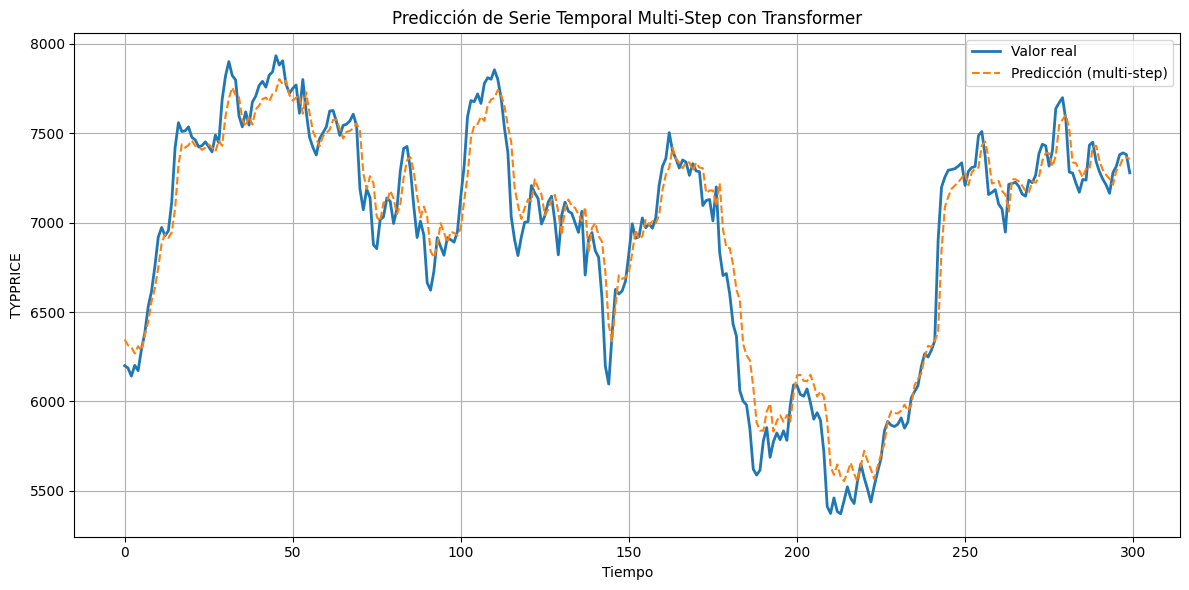

RMSE: 152.16
MAE: 114.18
MAPE: 1.70%
R²: 0.9478


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and preprocess data
url = "https://raw.githubusercontent.com/marsgr6/ml-online/main/data/BAJFINANCE_day__with_indicators_.csv"
df = pd.read_csv(url, parse_dates=["date"])
series = df["TYPPRICE"].dropna().values

# Parameters
seq_len = 10
horizon = 1
train_series = series[:-300]
test_series = series[-300:]

# Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_series.reshape(-1, 1)).flatten()
test_scaled = scaler.transform(test_series.reshape(-1, 1)).flatten()
full_test_input = np.concatenate([train_scaled[-seq_len:], test_scaled])

# Dataset for multi-step
class MultiStepTimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, horizon):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length
        self.horizon = horizon

    def __len__(self):
        return len(self.data) - self.seq_length - self.horizon + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length]
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.horizon]
        return x, y

# Prepare training
train_dataset = MultiStepTimeSeriesDataset(train_scaled, seq_len, horizon)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Transformer model with custom encoder layer
class TransformerTimeSeries(nn.Module):
    def __init__(self, seq_length, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=0.01,
            dim_feedforward=512,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, horizon)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = self.transformer(x)
        x = x[:, -1, :]
        return self.fc(x)

# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiStepTransformer(seq_length=seq_len, horizon=horizon).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(30):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[MultiStep] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
def create_multi_step_test_windows(data, seq_length, horizon):
    return torch.stack([data[i:i+seq_length] for i in range(len(data) - seq_length - horizon + 1)])

test_tensor = torch.tensor(full_test_input, dtype=torch.float32)
test_inputs = create_multi_step_test_windows(test_tensor, seq_len, horizon).to(device)

model.eval()
with torch.no_grad():
    preds = model(test_inputs).cpu().numpy()

# Flatten predictions and compare
predictions_flat = preds.flatten()
true_flat = test_series[:len(predictions_flat)]
predictions_original = scaler.inverse_transform(predictions_flat.reshape(-1, 1)).flatten()

# Metrics
rmse = np.sqrt(mean_squared_error(true_flat, predictions_original))
mae = mean_absolute_error(true_flat, predictions_original)
mape = np.mean(np.abs((true_flat - predictions_original) / true_flat)) * 100
r2 = r2_score(true_flat, predictions_original)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_flat, label="Valor real", linewidth=2)
plt.plot(predictions_original, label="Predicción (multi-step)", linestyle="--")
plt.title("Predicción de Serie Temporal Multi-Step con Transformer")
plt.xlabel("Tiempo")
plt.ylabel("TYPPRICE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

In [ ]:
len(predictions_original)

300

In [ ]:
# Re-execute the full multivariate Transformer model due to reset
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load multivariate dataset
url = "https://raw.githubusercontent.com/marsgr6/ml-online/main/data/BAJFINANCE_day__with_indicators_.csv"
df = pd.read_csv(url, parse_dates=["date"])
df = df.dropna()

# Features and target
features = ['TYPPRICE', 'SMA_5', 'EMA_5', 'RSI_14', 'MACD', 'UPPER_BB', 'LOWER_BB']
data = df[features].values

# Train/test split
seq_len = 10
train_data = data[:-300]
test_data = data[-300:]

# Normalize all variables jointly
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Combine last `seq_len` from training with test for prediction
full_test_input = np.concatenate([train_scaled[-seq_len:], test_scaled])

# Dataset for multivariate input
class MultivariateTimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_length, :]
        y = self.data[idx + self.seq_length, 0]  # predict TYPPRICE only
        return x, y

# Prepare training set
train_dataset = MultivariateTimeSeriesDataset(train_scaled, seq_len)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Transformer model for multivariate input
class MultivariateTransformer(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=0.1,
            dim_feedforward=256, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)     # (B, L, input_dim) → (B, L, d_model)
        x = self.transformer(x)   # (B, L, d_model)
        x = x[:, -1, :]           # último token
        return self.fc(x).squeeze(-1)

# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultivariateTransformer(input_dim=len(features)).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
for epoch in range(10):
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Multivariate] Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation
def create_multivariate_windows(data, seq_length):
    return torch.stack([torch.tensor(data[i:i+seq_length], dtype=torch.float32)
                        for i in range(len(data) - seq_length)])

test_inputs = create_multivariate_windows(full_test_input, seq_len).to(device)

model.eval()
with torch.no_grad():
    predictions = model(test_inputs).cpu().numpy()
    predictions_original = scaler.inverse_transform(
        np.hstack([predictions.reshape(-1, 1), np.zeros((len(predictions), len(features) - 1))])
    )[:, 0]

# Ground truth
real = test_data[seq_len:, 0]

# Metrics
rmse = np.sqrt(mean_squared_error(real, predictions_original))
mae = mean_absolute_error(real, predictions_original)
mape = np.mean(np.abs((real - predictions_original) / real)) * 100
r2 = r2_score(real, predictions_original)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(real, label="Valor real", linewidth=2)
plt.plot(predictions_original, label="Predicción multivariada Transformer", linestyle="--")
plt.title("Predicción de Serie Temporal Multivariada con Transformer")
plt.xlabel("Tiempo")
plt.ylabel("TYPPRICE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import numpy as np

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Hyperparameters ---
config = {
    "batch_size": 64,
    "lr": 3e-4,
    "epochs": 30,
    "image_size": 128,
    "patch_size": 8,
    "num_classes": 10,
    "weight_decay": 0.01,
    "dropout": 0.2,
    "embed_dim": 64,
    "num_heads": 8,
    "num_layers": 6,
    "ff_dim": 512
}

# --- Enhanced Data Augmentation ---
train_transform = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.RandomCrop(config["image_size"], padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # CIFAR-10 stats
])

test_transform = transforms.Compose([
    transforms.Resize(config["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# --- Data Loading ---
train_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform
)
test_data = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

train_loader = DataLoader(
    train_data,
    batch_size=config["batch_size"],
    shuffle=True,
    pin_memory=True,
    num_workers=2
)
test_loader = DataLoader(
    test_data,
    batch_size=config["batch_size"],
    pin_memory=True,
    num_workers=2
)

# --- Improved Model Architecture ---
class FastViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Sequential(
            nn.Conv2d(3, config["embed_dim"],
                     kernel_size=config["patch_size"],
                     stride=config["patch_size"]),
            nn.LayerNorm([config["embed_dim"],
                         config["image_size"]//config["patch_size"],
                         config["image_size"]//config["patch_size"]])
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=config["embed_dim"],
                nhead=config["num_heads"],
                dim_feedforward=config["ff_dim"],
                dropout=config["dropout"],
                batch_first=True,
                norm_first=True  # Pre-norm architecture
            ),
            num_layers=config["num_layers"]
        )
        self.head = nn.Sequential(
            nn.LayerNorm(config["embed_dim"]),
            nn.Linear(config["embed_dim"], 256),
            nn.GELU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(256, config["num_classes"])
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2).permute(0, 2, 1)
        x = self.transformer(x)
        return self.head(x.mean(dim=1))

# --- Training Setup ---
model = FastViT().to(device)
optimizer = optim.AdamW(
    model.parameters(),
    lr=config["lr"],
    weight_decay=config["weight_decay"]
)
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=config["epochs"] * len(train_loader),
    eta_min=1e-6
)
scaler = GradScaler()
criterion = nn.CrossEntropyLoss()

# --- Training Loop ---
best_acc = 0
for epoch in range(config["epochs"]):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'Loss': f"{loss.item():.3f}",
            'Acc': f"{100.*correct/total:.1f}%"
        })

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100.*val_correct/val_total
    print(f"\nValidation: Loss={val_loss/len(test_loader):.3f}, Acc={val_acc:.1f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vit_cifar10.pth")
        print(f"New best model saved! (Acc: {best_acc:.1f}%)")

# --- Evaluation ---
model.load_state_dict(torch.load("best_vit_cifar10.pth"))
model.eval()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Sample Predictions
def imshow(img):
    img = img * 0.2470 + 0.4914  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

images, labels = next(iter(test_loader))
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i].cpu())
    color = 'green' if preds[i] == labels[i] else 'red'
    plt.title(f"True: {train_data.classes[labels[i]]}\nPred: {train_data.classes[preds[i]]}",
              color=color)
plt.tight_layout()
plt.show()

print(f"\nFinal Best Accuracy: {best_acc:.1f}%")
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

Using device: cuda


<ipython-input-13-6a45b964bb0e>:127: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/30:   0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-13-6a45b964bb0e>:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30: 100%|██████████| 782/782 [01:46<00:00,  7.37it/s, Loss=1.510, Acc=31.4%]



Validation: Loss=1.614, Acc=40.5%
New best model saved! (Acc: 40.5%)


Epoch 2/30: 100%|██████████| 782/782 [01:39<00:00,  7.86it/s, Loss=1.156, Acc=42.7%]



Validation: Loss=1.449, Acc=46.3%
New best model saved! (Acc: 46.3%)


Epoch 3/30:  26%|██▋       | 207/782 [00:26<01:47,  5.37it/s, Loss=1.475, Acc=47.8%]

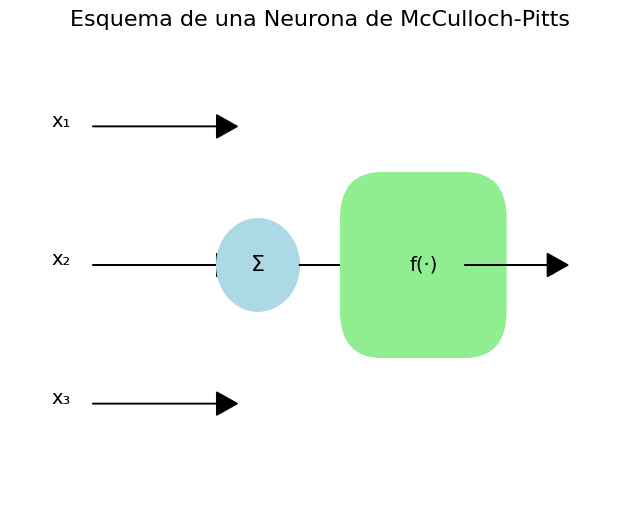

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Crear diagrama de una neurona de McCulloch-Pitts
fig, ax = plt.subplots(figsize=(8, 6))

# Entradas
inputs = ["x₁", "x₂", "x₃"]
for i, label in enumerate(inputs):
    ax.annotate(label, xy=(0.1, 0.8 - i*0.3), fontsize=14)
    ax.arrow(0.2, 0.8 - i*0.3, 0.3, 0, head_width=0.05, head_length=0.05, fc='black', ec='black')

# Suma ponderada
circle = patches.Circle((0.6, 0.5), 0.1, fill=True, color="lightblue", label="Suma")
ax.add_patch(circle)
ax.text(0.6, 0.5, "Σ", fontsize=16, ha="center", va="center")

# Activación
ax.arrow(0.7, 0.5, 0.2, 0, head_width=0.05, head_length=0.05, fc='black', ec='black')
rect = patches.FancyBboxPatch((0.9, 0.4), 0.2, 0.2, boxstyle="round,pad=0.1", color="lightgreen")
ax.add_patch(rect)
ax.text(1.0, 0.5, "f(·)", fontsize=14, ha="center", va="center")

# Salida
ax.arrow(1.1, 0.5, 0.2, 0, head_width=0.05, head_length=0.05, fc='black', ec='black')
ax.text(1.3, 0.5, "y", fontsize=14, va="center")

# Ajustes finales
ax.set_xlim(0, 1.5)
ax.set_ylim(0, 1)
ax.axis("off")
plt.title("Esquema de una Neurona de McCulloch-Pitts", fontsize=16)
plt.show()